## Set up workspace

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image

In [2]:
import glob
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.autograd import Function
from torch.autograd import Variable
from torchvision import models
import math
import torch.optim as optim

## Set up dataset

In [3]:
#Helper functions for pose preprocessing 
def isRotationMatrix(R):
    """ Checks if a matrix is a valid rotation matrix
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles/
    """
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotationMatrixToEulerAngles(R):
    """ calculates rotation matrix to euler angles
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles
    """
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

def getMatrix(line):
    p = np.array([line[3], line[7], line[11]])
    R = np.array([[line[0],line[1],line[2]],
                [line[4],line[5],line[6]],
                [line[8],line[9],line[10]]])
    angles = rotationMatrixToEulerAngles(R)
    matrix = np.concatenate((p,angles))
    return matrix

In [4]:
# Define dataset class
class KITTI_Dataset(Dataset):
    def __init__(self, images_path, poses_path, sequences=['00'], transform=None):
        self.images_path = images_path
        self.poses_path = poses_path
        self.sequences = sequences
        self.transform = transform
        self.image_files = self.load_image_files()
        self.pose_files = self.load_pose_files()

    def load_image_files(self):
        image_files = []
        for seq in self.sequences:
            for root, _, files in os.walk(os.path.join(self.images_path, seq, 'image_0')):
                for file in sorted(files):
                    if file.endswith('.png'):
                        image_files.append(os.path.join(root, file))
        return image_files

    def load_pose_files(self):
        pose_files = {}
        for seq in self.sequences:
            pose_file = os.path.join(self.poses_path, seq+'.txt')
            if os.path.exists(pose_file):
                if os.path.exists(pose_file):
                    try:
                        np.loadtxt(pose_file, dtype=np.float32)  # Test loading
                        pose_files[seq] = pose_file
                    except Exception as e:
                        print(f"Error loading pose file {pose_file}: {e}")
                else:
                    print(f"Pose file missing: {pose_file}")
        return pose_files

    def __len__(self):
        # To stack images, only consider until n-1
        return len(self.image_files)-1

    def __getitem__(self, idx):
        #print(f"Fetching index {idx}/{len(self.image_files)} (and next one)")
        img_path_1 = self.image_files[idx]
        img_path_2 = self.image_files[idx+1]
    
        # Load image
        #image = Image.open(img_path).convert('L')  # Load as grayscale
        #image = np.array(image, dtype=np.float32) / 255.0

        img_1 = cv2.imread(img_path_1)
        img_1 = cv2.resize(img_1, (1280,384), cv2.INTER_LINEAR)
        img_2 = cv2.imread(img_path_2)
        img_2 = cv2.resize(img_2, (1280,384), cv2.INTER_LINEAR)
        img = np.concatenate([img_1, img_2], axis = -1)
        img = np.reshape(img, (6, 384, 1280))
       
        #if self.transform:
            #image = self.transform(image)
        
        # Load corresponding pose if available
        seq = os.path.basename(os.path.dirname(os.path.dirname(img_path_1)))
        pose = None
        if seq in self.pose_files:
            img_idx = int(os.path.basename(img_path_1).split('.')[0])
            pose_file = self.pose_files[seq]

            with open(pose_file, 'r') as f:
                lines = f.readlines()     
                line_1 = np.fromstring(lines[img_idx], dtype=float, sep=' ')
                line_2 = np.fromstring(lines[img_idx+1], dtype=float, sep=' ')

            pose_1 = getMatrix(line_1)
            pose_2 = getMatrix(line_2)
            
            pose = pose_2 - pose_1

        #if pose is None:
            #pose = np.zeros((3, 4), dtype=np.float32)  # Placeholder for missing poses

        return torch.FloatTensor(img), torch.FloatTensor(pose)

## Network architecture

In [5]:
#Defining neural network as per RP by Sen Wang
class DeepVONet(nn.Module):
    def __init__(self):
        super(DeepVONet, self).__init__()

        self.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) #6 64
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d (64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d (128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3_1 = nn.Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.conv4_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.conv5_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d (512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.lstm1 = nn.LSTMCell(20*6*1024, 100)
        self.lstm2 = nn.LSTMCell(100, 100)
        self.fc = nn.Linear(in_features=100, out_features=6)

        self.reset_hidden_states()

    def reset_hidden_states(self, size=10, zero=True):
        if zero == True:
            self.hx1 = Variable(torch.zeros(size, 100))
            self.cx1 = Variable(torch.zeros(size, 100))
            self.hx2 = Variable(torch.zeros(size, 100))
            self.cx2 = Variable(torch.zeros(size, 100))
        else:
            self.hx1 = Variable(self.hx1.data)
            self.cx1 = Variable(self.cx1.data)
            self.hx2 = Variable(self.hx2.data)
            self.cx2 = Variable(self.cx2.data)

        if next(self.parameters()).is_cuda == True:
            self.hx1 = self.hx1.cuda()
            self.cx1 = self.cx1.cuda()
            self.hx2 = self.hx2.cuda()
            self.cx2 = self.cx2.cuda()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv6(x)
        #print(x.size())
        x = x.view(x.size(0), 20 * 6 * 1024)
        #print(x.size())
        self.hx1, self.cx1 = self.lstm1(x, (self.hx1, self.cx1))
        x = self.hx1
        self.hx2, self.cx2 = self.lstm2(x, (self.hx2, self.cx2))
        x = self.hx2
        #print(x.size())
        x = self.fc(x)
        return x

## Set up training and testing

In [55]:
# Training Function
def training_model(model, data_loader, device, epochs):

    start_time = time.time()
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        print("Epoch : ", epoch+1)
        for batch_idx, (images, poses) in enumerate(data_loader):
            print("Train num :", batch_idx+1)
            inputs = images.to(device)
            #print(len(inputs))
            labels = poses.to(device)
            #print(len(labels))
            model.zero_grad()
            model.reset_hidden_states()
            #optimizer.zero_grad()
            outputs = model(inputs)
            #if(epoch == (epoch_num-1) and (i > train_num-5)):
                #print("Outputs ", outputs)
                #print("Labels ", labels)
            #print(outputs)
            #print(labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('Epoch : %d Loss: %.3f' %(epoch+1, running_loss))


    print('Finished Training')
    print ("Time taken in Training {0}".format((time.time() - start_time)))

#Testing functions, it is predicting the output for test sequence as per the model
def testing_model (model, test_num, X):
    start_time = time.time()
    Y_output = []
    count = 0
    totcount = 0
    for i in range(test_num):
            # get the inputs
            inputs = X[i]
            outputs = model(inputs)
            Y_output.append(outputs)
    print ("Time taken in Testing {0}".format((time.time() - start_time)))
    return torch.stack(Y_output)

#Helper functions to get accuracy
def get_accuracy(outputs, labels, batch_size):
    diff =0
    for i in range(batch_size):
        for j in range(10):
            out = outputs[j].numpy()
            lab = labels[j].numpy()
            diff+=get_mse_diff(out,lab)
    #print("Loss : ",diff/(batch_size*10),"%")
    print("Accuracy : ",(1 -diff/(batch_size*10))*100,"%")
    
def get_mse_diff(x,y):
    diff= 0
    for i in range(6):
        diff += (x[i]-y[i])*(x[i]-y[i])
    return diff/6


## Training

In [6]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should display your GPU name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [57]:
#Creating model and defining loss and optimizer to be used 
model = DeepVONet().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.5)

In [13]:
data_path = 'C:\\Users\\benja\\Desktop\\visual-odometry'
images_path = os.path.join(data_path,'data_odometry_gray\\dataset\\sequences')
poses_path = os.path.join(data_path,'data_odometry_poses\\dataset\\poses')
sequences = ['03']

dataset = KITTI_Dataset(images_path, poses_path, sequences)
data_loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0, pin_memory=True)

In [59]:
training_model(model=model, data_loader=data_loader, device=device, epochs=3)

Epoch :  1
Train num : 1
Train num : 2
Train num : 3
Train num : 4
Train num : 5
Train num : 6
Train num : 7
Train num : 8
Train num : 9
Train num : 10
Train num : 11
Train num : 12
Train num : 13
Train num : 14
Train num : 15
Train num : 16
Train num : 17
Train num : 18
Train num : 19
Train num : 20
Train num : 21
Train num : 22
Train num : 23
Train num : 24
Train num : 25
Train num : 26
Train num : 27
Train num : 28
Train num : 29
Train num : 30
Train num : 31
Train num : 32
Train num : 33
Train num : 34
Train num : 35
Train num : 36
Train num : 37
Train num : 38
Train num : 39
Train num : 40
Train num : 41
Train num : 42
Train num : 43
Train num : 44
Train num : 45
Train num : 46
Train num : 47
Train num : 48
Train num : 49
Train num : 50
Train num : 51
Train num : 52
Train num : 53
Train num : 54
Train num : 55
Train num : 56
Train num : 57
Train num : 58
Train num : 59
Train num : 60
Train num : 61
Train num : 62
Train num : 63
Train num : 64
Train num : 65
Train num : 66
Train nu

In [61]:
#Save the model
torch.save(model.state_dict(), 'DeepVO.pt')

## Inference

In [22]:
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should display your GPU name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [23]:
data_path = 'C:\\Users\\benja\\Desktop\\visual-odometry'
images_path = os.path.join(data_path,'data_odometry_gray\\dataset\\sequences')
poses_path = os.path.join(data_path,'data_odometry_poses\\dataset\\poses')
sequences = ['03']

dataset = KITTI_Dataset(images_path, poses_path, sequences)
data_loader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0, pin_memory=True)

In [8]:
#Load model
model = DeepVONet().to(device)
model.load_state_dict(torch.load("DeepVO.pt", map_location=device))
model.eval()

C:\Users\benja\AppData\Local\Temp\ipykernel_20892\878473083.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("DeepVO.pt", map_location=de

DeepVONet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu3): ReLU(inplace=True)
  (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv4_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4_1): ReLU(inplace=True)
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5_1): ReLU(inplace=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm1): LSTMCell(122880, 1

In [27]:
outputs = []
with torch.no_grad():
    for batch_idx, (images, poses) in enumerate(data_loader):
        inputs = images.to(device)
        model.reset_hidden_states()
        output = model(inputs).detach().cpu()
        outputs.append(output)

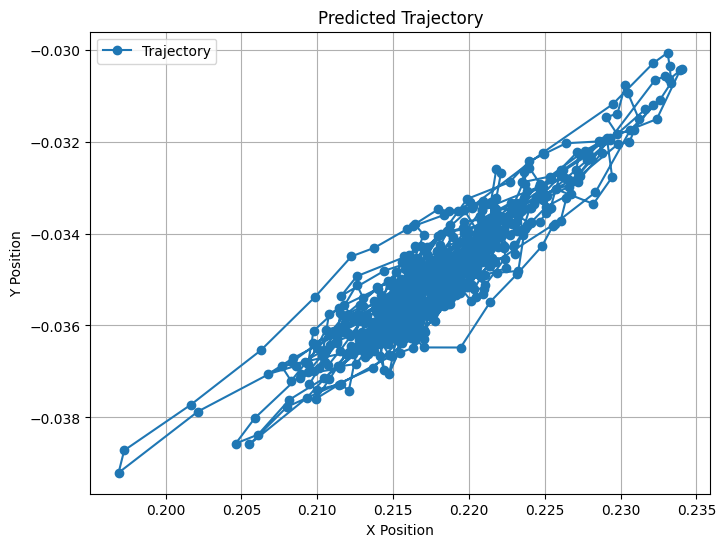

In [34]:
import matplotlib.pyplot as plt
import torch

all_outputs = torch.cat(outputs, dim=0)  # Concatenate along batch dimension

x_positions = all_outputs[:, 0].cpu().numpy()
y_positions = all_outputs[:, 1].cpu().numpy()

# Plot the x, y positions
plt.figure(figsize=(8, 6))
plt.plot(x_positions, y_positions, marker='o', linestyle='-', label="Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Predicted Trajectory")
plt.legend()
plt.grid(True)
plt.show()

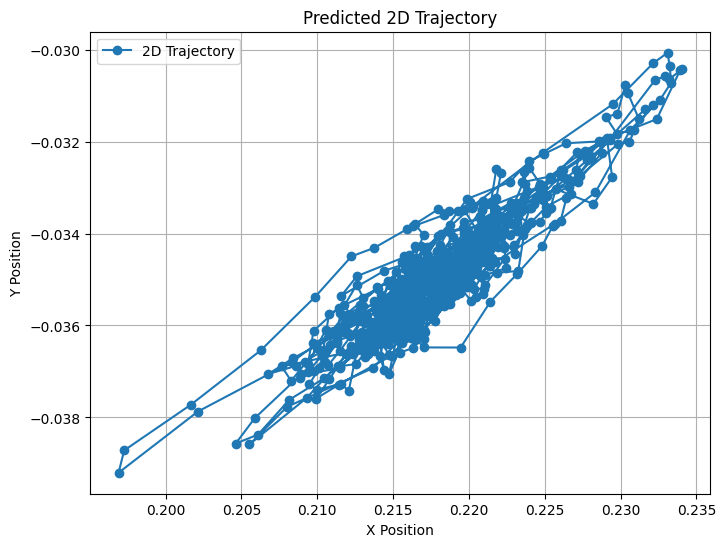

In [30]:
# Extract x and y positions for a 2D trajectory
x_positions = all_outputs[:, 0].cpu().numpy()  # x values
y_positions = all_outputs[:, 1].cpu().numpy()  # y values

# Plot the x, y trajectory
plt.figure(figsize=(8, 6))
plt.plot(x_positions, y_positions, marker='o', linestyle='-', label="2D Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Predicted 2D Trajectory")
plt.legend()
plt.grid(True)
plt.show()


(801, 12)


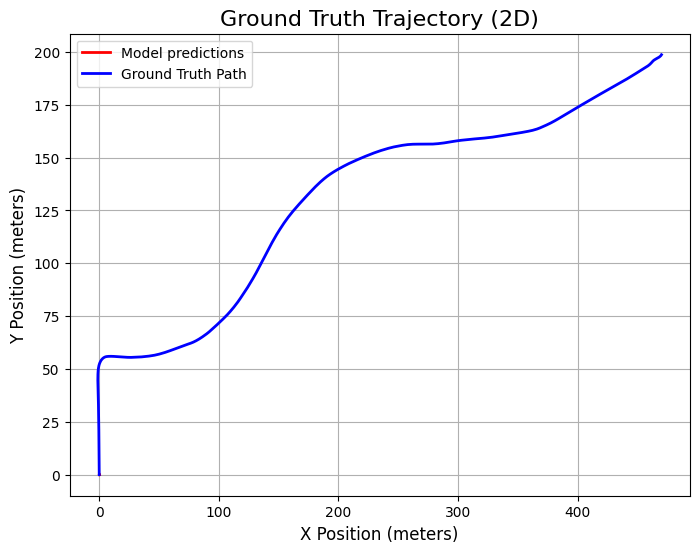

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the ground truth poses (1x12 vectors from the 'poses.txt' file)
ground_truth_poses = np.loadtxt('03.txt')  # shape: (N, 12)

print(ground_truth_poses.shape)

# Extract x and y coordinates (ignoring the orientation)
ground_truth_poses = ground_truth_poses.reshape(len(ground_truth_poses), 3, 4) #reshape into Homogeneous matrix

x_positions = ground_truth_poses[:,:,-1][:, 0]
y_positions = ground_truth_poses[:,:,-1][:, 2] # z is the y coordinate in the 2D plane seen from above (z points forward in the camera frame)


# replace this with your model predictions
pred_poses_x = all_outputs[:, 0].cpu().numpy()  # x values
pred_poses_y = all_outputs[:, 1].cpu().numpy()  # y values

# calculate metrics
# rmse = ...

# Plot the ground truth trajectory in 2D (X-Y plane)
plt.figure(figsize=(8, 6))
plt.plot(pred_poses_x, pred_poses_y, label='Model predictions', color='r', linewidth=2)
plt.plot(x_positions, y_positions, label='Ground Truth Path', color='b', linewidth=2)
plt.title('Ground Truth Trajectory (2D)', fontsize=16)
plt.xlabel('X Position (meters)', fontsize=12)
plt.ylabel('Y Position (meters)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()